In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import curve_fit
import seaborn as sns
import random
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

### Scaling of the matrix-matrix multiplication

In [2]:
def create_matrix(rows, columns):
    """
    Function that creates a random matrix of integers with dimension rows x columns
    """
    matrix = []
    for i in range(rows):
        row = [random.randint(1,10) for j in range(columns)]
        matrix.append(row)
    return matrix

Write two diffferent order loops for multiplying matrices

In [3]:
def matrix_mulRow(matrix1,matrix2):
    """
    Matrix-Matrix multiplication with row-wise selection
    """
    result = []
    for i in range(len(matrix1[0])):
        row = []
        for j in range(len(matrix2[1])):
            entries_sum = 0
            for k in range(len(matrix1[1])):
                entries_sum += matrix1[i][k]*matrix2[k][j]
            row.append(entries_sum)
        result.append(row)
    
    return result

In [4]:
def matrix_mulColumn(matrix1,matrix2):
    """
    Matrix-Matrix multiplication with column-wise selection
    """
    result = []
    for i in range(len(matrix2[0])):
        row = []
        for j in range(len(matrix1[1])):
            entries_sum = 0
            for k in range(len(matrix1[1])):
                entries_sum += matrix1[i][k]*matrix2[k][j]
            row.append(entries_sum)
        result.append(row)
    
    return result

Write a function that changes $N$ between two values $N_{min}$ and $N_{max}$

In [5]:
def scaling_matrix_product(N_min, N_max, method, step = 10, write_mode = "a"):
    """
    Funtion that does matrix-matrix multiplications with a given method.
    Parameters:
        N_min: minimum value of the input matrices
        N_max: maximum value of the input matrices
        method: takes the name of the function used to multiply the matrices
        write_mode: mode to store the results
            (default) "a": appends data to an existing file
            (optional) "w": creates a new file with the results
    """
    times = []
    for i in range(N_min, N_max, step):
        matrix_A = create_matrix(i,i)
        matrix_B = create_matrix(i,i)
        
        t_i = datetime.now()
        method(matrix_A, matrix_B)
        t_f = datetime.now()
        
        delta_t = t_f - t_i # Measures the time it took to make the matrix product
        times.append(delta_t.seconds + delta_t.microseconds*1e-6)
        
    # Save execution times in a file
    filename = "execution_time_{}.txt".format(method.__name__)
    with open("Assignment3/"+filename, write_mode) as file:
        for j in range(len(times)):
            file.write("{};{}\n".format(range(N_min, N_max, step)[j], times[j]))
        
    return times

In [6]:
N_min = 500
N_max = 700
#scaling_matrix_product(N_min,N_max,matrix_mulRow)
#scaling_matrix_product(N_min,N_max,matrix_mulColumn)
#scaling_matrix_product(N_min,N_max,np.matmul)
print("Done")

Done


Read the stored results and fit the function

In [7]:
df_row = pd.read_csv("Assignment3/execution_time_matrix_mulRow.txt", sep=";")
df_row['method'] = "Row-wise"
df_col = pd.read_csv("Assignment3/execution_time_matrix_mulColumn.txt", sep=";")
df_col['method'] = "Column-wise"
df_numpy = pd.read_csv("Assignment3/execution_time_matmul.txt", sep=";")
df_numpy['method'] = "Numpy-inner"

# Join all data to have it only in one dataframe
df = pd.concat([df_row, df_col, df_numpy])
df = df[df['time']!=0]

In [8]:
for i in df['method'].unique():
    prov_df = df[df['method'] == i]
    fit = np.polyfit(np.log(prov_df["N"]), np.log(prov_df["time"]), 1)
    print("Exponent fit of {} method: {}".format(i, fit[0]))

Exponent fit of Row-wise method: 2.9312290453271492
Exponent fit of Column-wise method: 2.913529698963001
Exponent fit of Numpy-inner method: 2.5150148867837623


For each method, a linear fit was made. The constant of the first order logarithm is the exponent of the scaling. 

In [9]:
df.tail()

,N,time,method
378,650,0.459000,Numpy-inner
379,660,0.493000,Numpy-inner
380,670,0.500000,Numpy-inner
381,680,0.522014,Numpy-inner
382,690,0.548002,Numpy-inner


Text(0.5, 1.0, 'Scaling of matrix-matrix multiplication')

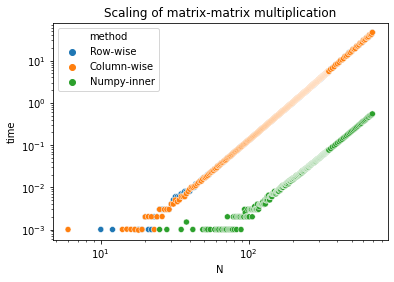

In [10]:
sns.scatterplot(data=df, x='N', y='time', hue='method')
plt.yscale('log')
plt.xscale('log')
plt.title('Scaling of matrix-matrix multiplication')

Log-Log plot of the execution time as a function of the matrix dimension. With a $N$ sufficienty large, one can observe a linear correlation.

### Eigenproblem

Consider a random Hermitian matrix $A$ of size $N$

For a matrix to be Hermitian, one has to consider a square complex matrix that is equal to its own conjugate transpose. 

In [11]:
def create_hermitian(N):
    """
    Creates a hermitian matrix of dimension N x N
    """
    # Creates a random square complex matrix
    random_matrix = np.random.rand(N,N) + 1j*np.random.rand(N,N)
    
    # Make the matrix hermitian
    hermitian_matrix = (random_matrix + np.conj(random_matrix.T))/2
    
    return hermitian_matrix

Compute the normalized spacing between eigenvalues

In [12]:
def normalized_spacing(N):
    """
    Compute the normalized spacing between eigenvalues of a function
    Parameters:
        N: dimension of the Hermitian matrix
    """
    A = create_hermitian(N)
    eigenvalues = np.linalg.eigh(A, "L")[0]
    
    spacing = []
    for i in range(len(eigenvalues) - 1):
        space = eigenvalues[i+1] - eigenvalues[i]
        spacing.append(space)
    space_avg = sum(spacing)/len(spacing)
    norm_spacing = spacing/space_avg
    
    return norm_spacing[:-1]

### Random matrix theory

Study the distribution of normalized spacings from different random matrices

In [13]:
cant = 10 # number of random matrices
N = 1500 # dimension of each matrix
norms_spacings = []
for i in range(cant):
    norms_spacings.append(normalized_spacing(N))

In [14]:
spacings_final = []
for i in norms_spacings:
    spacings_final = [*spacings_final, *i]
bins = 50

In [15]:
def probability_distribution(data, bins):
    # Create histogram which area is normalized to 1
    hist, bin_edge = np.histogram(data, bins=bins,density=True)
    
    # Compute the probability for each bin
    centre = (bin_edge[:-1] + bin_edge[1:])/2
    prob_distr = {centre[i]: hist[i] for i in range(len(hist))}
    
    return prob_distr

In [16]:
avg_prob_dist = probability_distribution(spacings_final, bins)

Text(0, 0.5, 'P(s)')

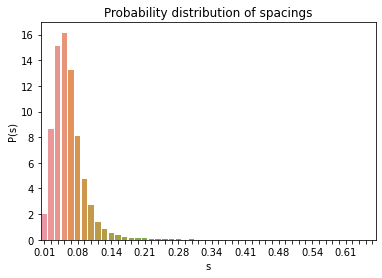

In [31]:
density_plot = sns.barplot(x=list(avg_prob_dist.keys()), y = list(avg_prob_dist.values()))

labels = [item.get_text() for item in density_plot.get_xticklabels()]
density_plot.set_xticklabels([round(float(label), 2) for label in labels])

for ind, label in enumerate(density_plot.get_xticklabels()):
    if ind % 5 == 0:  # every 5th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
        
plt.title("Probability distribution of spacings")
plt.xlabel("s")
plt.ylabel("P(s)")

Fit the distributions with the function $P(s) = as^\alpha \exp(bs^\beta)$

In [18]:
def exp_func(x,a,b,alpha,beta):
    return a*x**alpha*np.exp(b*x**beta)

In [19]:
popt, pcov = curve_fit(exp_func, list(avg_prob_dist.keys()), list(avg_prob_dist.values()), p0=[50000,-400,2,2], maxfev=5000)

In [26]:
x = np.linspace(min(list(avg_prob_dist.keys())),max(list(avg_prob_dist.keys())))
y = exp_func(x,popt[0], popt[1], popt[2], popt[3])

<AxesSubplot:>

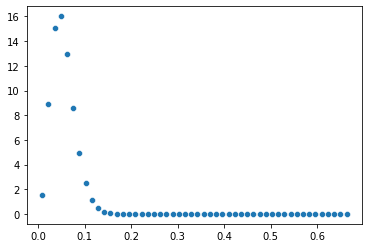

In [27]:
sns.scatterplot(x,y)

In [22]:
print("alpha = {}\nbeta = {}".format(popt[2], popt[3]))

alpha = 2.3109057262052355
beta = 1.4657771370526556
